<a href="https://colab.research.google.com/github/antunesclarissa/colab/blob/main/NLS-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas pyarrow openpyxl

In [10]:
import pandas as pd
import os
import re
from openpyxl import load_workbook  # Para leitura de Excel com openpyxl

# =============================================================================
# Função: extrair_nome_coluna
# =============================================================================
def extrair_nome_coluna(nome_coluna):
    """
    Extrai a parte do nome da coluna antes do delimitador " : ".

    Exemplo:
        "NOME : INFO EXTRA" -> "NOME"
    """
    return nome_coluna.split(" : ")[0]

# =============================================================================
# Função: renomear_colunas
# =============================================================================
def renomear_colunas(nome_coluna):
    """
    Renomeia o nome da coluna com base em padrões pré-definidos.

    Aplica expressões regulares para identificar:
      - Padrões de perguntas (ex.: P2, P2a, P2b, P3a, P3b, P4B), gerando:
            CAT{categoria}_{pergunta}_M{marca} ou CAT{categoria}_{pergunta}
      - Padrões de atributos (ex.: P2Ca, P2Cb), gerando:
            CAT{categoria}_{pergunta}_AT{atributo}_M{marca} (com ajuste para P2Cb)
    """
    nome_coluna_limpo = extrair_nome_coluna(nome_coluna)

    padrao_pergunta = re.compile(r'(P2|P2[ab]|P3[ab]|P4B)_(\d+)(?:_(\d+))?', re.IGNORECASE)
    padrao_atributo = re.compile(r'(P2Ca|P2Cb)_(\d+)_(\d+)_(\d+)', re.IGNORECASE)

    match_pergunta = padrao_pergunta.match(nome_coluna_limpo)
    if match_pergunta:
        pergunta, primeiro_numero, segundo_numero = match_pergunta.groups()
        if segundo_numero:
            categoria = segundo_numero
            marca = primeiro_numero
            novo_nome = f'CAT{categoria}_{pergunta}_M{marca}'
        else:
            categoria = primeiro_numero
            novo_nome = f'CAT{categoria}_{pergunta}'
        return novo_nome

    match_atributo = padrao_atributo.match(nome_coluna)
    if match_atributo:
        pergunta, atributo, marca, categoria = match_atributo.groups()
        atributo = int(atributo)
        if 'P2Cb' in pergunta:
            atributo += 12
        novo_nome = f'CAT{categoria}_{pergunta}_AT{atributo}_M{marca}'
        return novo_nome

    return nome_coluna

# =============================================================================
# Função: remover_linhas_colunas_vazias
# =============================================================================
def remover_linhas_colunas_vazias(df):
    """
    Substitui strings vazias por NA e remove linhas e colunas inteiramente vazias.
    """
    # Considera células com espaços ou strings vazias como NA
    df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
    df = df.dropna(how='all')         # Remove linhas completamente vazias
    df = df.dropna(axis=1, how='all')    # Remove colunas completamente vazias
    return df

# =============================================================================
# Função: converter_para_categorias
# =============================================================================
def converter_para_categorias(df):
    """
    Converte colunas para 'category' se a proporção de valores únicos for inferior a 50%.
    """
    for col in df.columns:
        if df[col].dtype == 'object':
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')
    return df

# =============================================================================
# Função: processar_arquivo_excel
# =============================================================================
def processar_arquivo_excel(caminho_entrada, caminho_saida):
    """
    Processa um arquivo Excel:
      - Lê o arquivo utilizando openpyxl;
      - Remove as duas primeiras colunas;
      - Conta e remove linhas e colunas completamente vazias;
      - Renomeia as colunas conforme os padrões definidos;
      - Converte colunas para 'category' quando aplicável;
      - Salva o DataFrame processado em um novo arquivo Excel.
    """
    # Leitura do arquivo Excel
    df = pd.read_excel(caminho_entrada, engine='openpyxl')

    # Remove as duas primeiras colunas
    df = df.iloc[:, 2:]
    print(f"Dimensões do DataFrame após remover as duas primeiras colunas: {df.shape}")

    # Conta linhas vazias antes da remoção
    linhas_vazias = df.isna().all(axis=1).sum()
    print(f"Número de linhas completamente vazias (antes da remoção): {linhas_vazias}")

    # Remove linhas e colunas completamente vazias
    df = remover_linhas_colunas_vazias(df)
    print(f"Dimensões do DataFrame após remoção de linhas e colunas vazias: {df.shape}")

    # Renomeia as colunas utilizando os padrões definidos
    colunas_renomeadas = [renomear_colunas(coluna) for coluna in df.columns]
    mapeamento = dict(zip(df.columns, colunas_renomeadas))
    df = df.rename(columns=mapeamento)

    # Converte colunas para 'category' quando aplicável
    df = converter_para_categorias(df)

    # Salva o DataFrame processado em um novo arquivo Excel
    df.to_excel(caminho_saida, index=False)
    print(f"Arquivo processado e salvo como: {caminho_saida}")

    return df

# =============================================================================
# Execução do Processamento para o Arquivo Único: NLS2023_Bancos_Tradicionais.xlsx
# =============================================================================

# Defina o diretório onde o arquivo está localizado
caminho_pasta = "/content/NLS"

# Nome do arquivo de entrada
arquivo_entrada = "/content/NLS/NLS2023_Bancos_Tradicionais.xlsx"
caminho_entrada = os.path.join(caminho_pasta, arquivo_entrada)

# Nome do arquivo de saída
arquivo_saida = "NLS2023_Bancos_Tradicionais_tratado.xlsx"
caminho_saida = os.path.join(caminho_pasta, arquivo_saida)

# Processa o arquivo Excel
df_processado = processar_arquivo_excel(caminho_entrada, caminho_saida)

Dimensões do DataFrame após remover as duas primeiras colunas: (3453, 346)
Número de linhas completamente vazias (antes da remoção): 3008
Dimensões do DataFrame após remoção de linhas e colunas vazias: (445, 346)
Arquivo processado e salvo como: /content/NLS/NLS2023_Bancos_Tradicionais_tratado.xlsx


In [11]:
import pandas as pd
import os
import re

# =============================================================================
# FUNÇÃO: dividir_e_salvar_arquivo
# =============================================================================
def dividir_e_salvar_arquivo(nome_arquivo_original, caminho_saida, regex_arquivo_1, regex_arquivo_2):
    """
    Lê um arquivo Excel processado (já tratado), filtra as colunas que correspondem a dois
    conjuntos distintos (baseados em expressões regulares) e salva cada conjunto em um arquivo Excel separado.

    Exemplo: separar atributos de "amor" e "NPS":
      - regex_arquivo_1: Filtra colunas para atributos de "amor" (por exemplo, contendo "P2a", "P2Ca" ou "P2Cb").
      - regex_arquivo_2: Filtra colunas para atributos de "NPS" (por exemplo, contendo "P4B", além de "P2Ca" e "P2Cb" se necessário).

    Parâmetros:
      nome_arquivo_original (str): Caminho do arquivo Excel já tratado.
      caminho_saida (str): Diretório onde os novos arquivos serão salvos.
      regex_arquivo_1 (regex): Expressão regular para filtrar colunas do grupo "amor".
      regex_arquivo_2 (regex): Expressão regular para filtrar colunas do grupo "NPS".
    """
    # Ler o arquivo Excel tratado
    df = pd.read_excel(nome_arquivo_original)

    # Filtrar as colunas para cada grupo com base nas expressões regulares
    colunas_arquivo_1 = [col for col in df.columns if regex_arquivo_1.search(col)]
    colunas_arquivo_2 = [col for col in df.columns if regex_arquivo_2.search(col)]

    # Exibir contagens para validação
    print(f"Número de colunas selecionadas para 'Amor': {len(colunas_arquivo_1)}")
    print(f"Número de colunas selecionadas para 'NPS': {len(colunas_arquivo_2)}")

    # Criar DataFrames para cada grupo de colunas
    df_arquivo_1 = df[colunas_arquivo_1]
    df_arquivo_2 = df[colunas_arquivo_2]

    # Definir os caminhos de saída completos
    caminho_saida_1 = os.path.join(caminho_saida, "Categorias_Amor_AT.xlsx")
    caminho_saida_2 = os.path.join(caminho_saida, "Categorias_NPS_AT.xlsx")

    # Salvar os DataFrames em arquivos Excel separados
    df_arquivo_1.to_excel(caminho_saida_1, index=False)
    df_arquivo_2.to_excel(caminho_saida_2, index=False)

    print(f"Arquivo 'Amor' salvo em: {caminho_saida_1}")
    print(f"Arquivo 'NPS' salvo em: {caminho_saida_2}")

# =============================================================================
# EXECUÇÃO DO SCRIPT DE DIVISÃO
# =============================================================================

# Arquivo já tratado (gerado no Script 1)
nome_arquivo_original = "/content/NLS/NLS2023_Bancos_Tradicionais_tratado.xlsx"

# Diretório de saída (no Google Colab, normalmente "/content/")
caminho_saida = "/content/NLS"

# Compilar as expressões regulares para filtrar as colunas desejadas
regex_arquivo_1 = re.compile(r'.*P2a.*|.*P2Ca.*|.*P2Cb.*')  # Grupo de "amor"
regex_arquivo_2 = re.compile(r'.*P4B.*|.*P2Ca.*|.*P2Cb.*')   # Grupo de "NPS"

# Executa a função para dividir e salvar os grupos
dividir_e_salvar_arquivo(nome_arquivo_original, caminho_saida, regex_arquivo_1, regex_arquivo_2)

Número de colunas selecionadas para 'Amor': 299
Número de colunas selecionadas para 'NPS': 299
Arquivo 'Amor' salvo em: /content/NLS/Categorias_Amor_AT.xlsx
Arquivo 'NPS' salvo em: /content/NLS/Categorias_NPS_AT.xlsx


In [16]:
import pandas as pd

def processar_e_salvar_arquivo(caminho_arquivo_entrada, caminho_arquivo_saida):
    # Ler o arquivo excel
    df = pd.read_excel(caminho_arquivo_entrada)

    # Imprimir o tamanho do DataFrame antes da remoção
    print(f'Tamanho do DataFrame antes da remoção: {df.shape} (Linhas, Colunas)')

    # Contar o número de linhas vazias
    linhas_vazias = df.isna().all(axis=1).sum()

    # Imprimir o resultado da verificação
    if linhas_vazias == 0:
        print("Não existem linhas completamente vazias no arquivo.")
    else:
        print(f"Existem {linhas_vazias} linhas completamente vazias no arquivo.")

    # Remover linhas que são completamente vazias
    df_limpo = df.dropna(how='all')

    # Imprimir o tamanho do DataFrame após a remoção
    print(f'Tamanho do DataFrame após a remoção: {df_limpo.shape} (Linhas, Colunas)')

    # Salvar o DataFrame limpo em um novo arquivo excel
    df_limpo.to_excel(caminho_arquivo_saida, index=False)
    print(f'Arquivo salvo após remover linhas vazias: {caminho_arquivo_saida}')

# Caminho do arquivo original
caminho_arquivo_entrada = "/content/NLS/Categorias_Amor_AT.xlsx"

# Caminho para salvar o arquivo após a remoção das linhas vazias
caminho_arquivo_saida = "/content/NLS/Categorias_Amor_AT_sem_linhas.xlsx"

# Executar a função
processar_e_salvar_arquivo(caminho_arquivo_entrada, caminho_arquivo_saida)

Tamanho do DataFrame antes da remoção: (443, 299) (Linhas, Colunas)
Existem 88 linhas completamente vazias no arquivo.
Tamanho do DataFrame após a remoção: (355, 299) (Linhas, Colunas)
Arquivo salvo após remover linhas vazias: /content/NLS/Categorias_Amor_AT_sem_linhas.xlsx


In [19]:
import pandas as pd
import numpy as np
import re

# Carregar o DataFrame
df = pd.read_excel('/content/NLS/Categorias_Amor_AT_sem_linhas.xlsx')

# Definir um tamanho de lote (número de colunas a processar por vez)
tamanho_lote = 500

# Expressões regulares para identificar as colunas de variáveis dependentes e independentes
regex_var_dep = re.compile('.*P2a.*')
regex_var_indep = re.compile('.*P2Ca.*|.*P2Cb.*')

# Tratar valores ausentes em lotes
for i in range(0, len(df.columns), tamanho_lote):
    colunas_lote = df.columns[i:i + tamanho_lote]
    for coluna in colunas_lote:
        if regex_var_dep.search(coluna):
            df[coluna] = df[coluna].fillna(np.nan)
        elif regex_var_indep.search(coluna):
            df[coluna] = df[coluna].fillna(0)

# Salvar o DataFrame tratado
df.to_excel('/content/NLS/Categorias_Amor_AT_NaN.xlsx', index=False)

In [21]:
import pandas as pd
import numpy as np
import re

# Função para classificar em grupos multiclasse
def classificar_grupo(nota):
    if pd.isna(nota):
        return np.nan
    elif nota >= 9:
        return 1  # Grupo G1
    elif nota >= 7:
        return 2  # Grupo G2
    elif nota >= 5:
        return 3  # Grupo G3
    else:
        return 4  # Grupo G4

# Caminho do arquivo
caminho_arquivo = '/content/NLS/Categorias_Amor_AT_NaN.xlsx'

# Ler o arquivo excel
df = pd.read_excel(caminho_arquivo)

# Identificar categorias
categorias = set(col.split('_')[0] for col in df.columns if 'P2a' in col)

# Processar cada categoria
for categoria in categorias:
    # Filtrar colunas da categoria
    colunas_categoria = df.filter(regex=f'{categoria}_P2a.*').columns

    # Classificar respostas e criar colunas de grupo
    df_categoria = df[colunas_categoria].map(classificar_grupo)
    for grupo in range(1, 5):
        df[f'{categoria}_G{grupo}'] = (df_categoria == grupo).any(axis=1).astype(int)

    # Remover colunas originais da categoria
    df.drop(colunas_categoria, axis=1, inplace=True)

# Salvar o DataFrame processado
df.to_excel('/content/NLS/Categorias_Amor_AT_grupos.xlsx', index=False)

In [23]:
import pandas as pd

# Caminho do arquivo
caminho_arquivo = '/content/NLS/Categorias_Amor_AT_grupos.xlsx'

# Ler o arquivo excel
df = pd.read_excel(caminho_arquivo)

# Verificar se existem colunas com 'P2a'
colunas_p2a = [col for col in df.columns if 'P2a' in col]

# Imprimir se colunas com 'P2a' existem
if not colunas_p2a:
    print("Todas as colunas contendo 'P2a' foram removidas.")
else:
    print("Ainda existem colunas contendo 'P2a':")
    print(colunas_p2a)

# Verificar se existem colunas com 'P4B'
colunas_p4b = [col for col in df.columns if 'P4B' in col]

# Imprimir se colunas com 'P4B' existem
if not colunas_p4b:
    print("Todas as colunas contendo 'P4B' foram removidas.")
else:
    print("Ainda existem colunas contendo 'P4B':")
    print(colunas_p4b)

# Verificar e imprimir o tamanho do DataFrame
print(f"Dimensões do DataFrame: {df.shape} (Linhas, Colunas)")

Todas as colunas contendo 'P2a' foram removidas.
Todas as colunas contendo 'P4B' foram removidas.
Dimensões do DataFrame: (355, 292) (Linhas, Colunas)


Arquivo carregado.
Variáveis independentes selecionadas: (355, 288)

Treinando modelo para CAT7_G1...

Treinando modelo para CAT7_G2...

Treinando modelo para CAT7_G3...

Treinando modelo para CAT7_G4...
Relatórios de classificação salvos em: /content/NLS/Amor_regressao_relatorios_class.xlsx


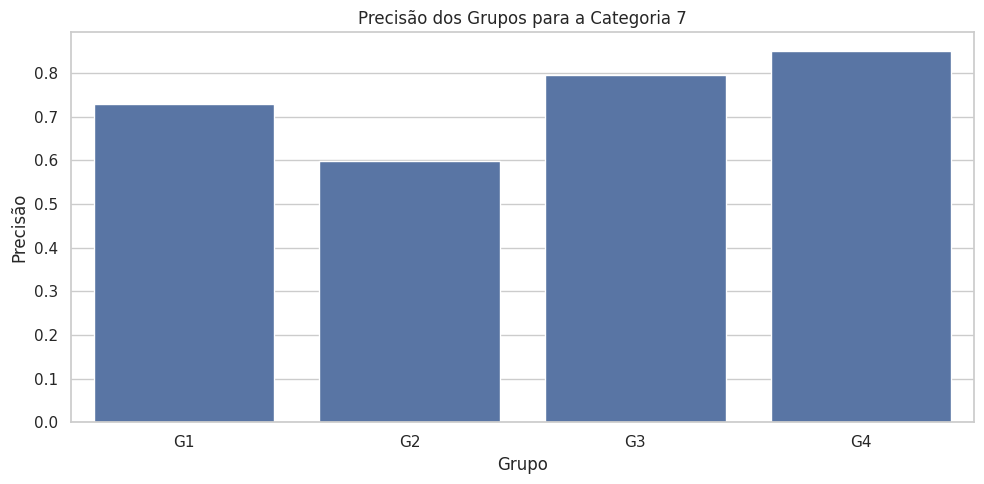


Resumo dos Resultados para Categoria 7:

Resultados para Categoria 7 - Grupo G1:
Acurácia: 0.73
Precisão: 0.73
Recall: 0.73
F1-score: 0.70


Resultados para Categoria 7 - Grupo G2:
Acurácia: 0.60
Precisão: 0.76
Recall: 0.60
F1-score: 0.45


Resultados para Categoria 7 - Grupo G3:
Acurácia: 0.79
Precisão: 0.84
Recall: 0.79
F1-score: 0.70


Resultados para Categoria 7 - Grupo G4:
Acurácia: 0.85
Precisão: 0.87
Recall: 0.85
F1-score: 0.78



In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# =============================================================================
# ETAPA 1: LEITURA DOS DADOS PROCESSADOS
# =============================================================================
# Carrega o DataFrame processado contendo os grupos de "amor"
# O arquivo deve conter as colunas, por exemplo, "CAT7_G1", "CAT7_G2", "CAT7_G3" e "CAT7_G4"
df = pd.read_excel('/content/NLS/Categorias_Amor_AT_grupos.xlsx')
print("Arquivo carregado.")

# =============================================================================
# ETAPA 2: DEFINIÇÃO DAS VARIÁVEIS INDEPENDENTES (X)
# =============================================================================
# Seleciona as colunas que representam os atributos independentes (variáveis preditoras)
# Neste caso, as colunas que contêm "P2Ca" ou "P2Cb"
X = df.filter(regex='P2Ca|P2Cb')
print(f"Variáveis independentes selecionadas: {X.shape}")

# =============================================================================
# ETAPA 3: TREINAMENTO DOS MODELOS DE REGRESSÃO LOGÍSTICA PARA A CATEGORIA 7
# =============================================================================
# Como estamos lidando com uma única categoria (7), definimos:
categoria = 7
resultados = {categoria: {}}

for grupo in ['G1', 'G2', 'G3', 'G4']:
    nome_coluna_grupo = f'CAT{categoria}_{grupo}'
    if nome_coluna_grupo in df.columns:
        y = df[nome_coluna_grupo]
        print(f"\nTreinando modelo para {nome_coluna_grupo}...")

        # Dividir os dados em conjuntos de treino e teste com amostragem estratificada
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.3,
                                                            random_state=42,
                                                            stratify=y)
        # Treinar modelo de regressão logística com validação cruzada (5 folds)
        modelo = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000, random_state=42).fit(X_train, y_train)

        # Avaliar modelo
        y_pred = modelo.predict(X_test)
        report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)

        # Armazenar os resultados
        resultados[categoria][grupo] = {
            'modelo': modelo,
            'report': report
        }
    else:
        print(f"A coluna {nome_coluna_grupo} não foi encontrada no DataFrame.")

# =============================================================================
# ETAPA 4: CONSOLIDAÇÃO DOS RELATÓRIOS DE CLASSIFICAÇÃO E SALVAMENTO
# =============================================================================
relatorios_df = []  # Inicializa uma lista
for cat, dados_categoria in resultados.items():
    for grupo, dados_grupo in dados_categoria.items():
        # Extrai o relatório completo
        report_completo = dados_grupo['report']
        # Extrai o valor global de acurácia
        overall_accuracy = report_completo.get('accuracy', None)
        # Extrai o dicionário 'weighted avg'
        weighted_avg = report_completo.get('weighted avg', {})
        # Adiciona o valor de acurácia ao dicionário de weighted avg
        weighted_avg['accuracy'] = overall_accuracy
        # Cria um DataFrame temporário e adiciona informações de categoria e grupo
        report_df = pd.DataFrame([weighted_avg])
        report_df['categoria'] = cat
        report_df['grupo'] = grupo
        relatorios_df.append(report_df)

# Concatenar a lista de DataFrames em um único DataFrame
relatorios_df = pd.concat(relatorios_df, ignore_index=True)

# Salvar os relatórios em um arquivo Excel
relatorios_df.to_excel('/content/NLS/Amor_regressao_relatorios_class.xlsx', index=False)
print("Relatórios de classificação salvos em: /content/NLS/Amor_regressao_relatorios_class.xlsx")

# =============================================================================
# ETAPA 5: PLOTAGEM DAS MÉTRICAS
# =============================================================================
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(resultados), ncols=1, figsize=(10, 5 * len(resultados)))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
for i, (cat, grupos) in enumerate(resultados.items()):
    # Coleta a acurácia para cada grupo da categoria
    precisoes = [grupo_info['report']['accuracy'] for grupo_info in grupos.values()]
    sns.barplot(ax=axes[i], x=list(grupos.keys()), y=precisoes)
    axes[i].set_title(f'Precisão dos Grupos para a Categoria {cat}')
    axes[i].set_ylabel('Precisão')
    axes[i].set_xlabel('Grupo')
plt.tight_layout()
plt.show()

# =============================================================================
# ETAPA 6: GERAÇÃO DE EXPLICAÇÕES TEXTUAIS DOS RESULTADOS
# =============================================================================
def gerar_explicacao(report):
    """
    Gera uma explicação textual para um relatório de classificação.
    """
    # Utiliza .get() para evitar KeyError caso alguma métrica não esteja presente
    return (
        f"Acurácia: {report.get('accuracy', 0):.2f}\n"
        f"Precisão: {report.get('precision', 0):.2f}\n"
        f"Recall: {report.get('recall', 0):.2f}\n"
        f"F1-score: {report.get('f1-score', 0):.2f}\n"
    )

print("\nResumo dos Resultados para Categoria 7:")
for grupo in ['G1', 'G2', 'G3', 'G4']:
    if grupo in resultados[categoria]:
        report = resultados[categoria][grupo]['report']['weighted avg']
        explicacao = gerar_explicacao(report)
        print(f"\nResultados para Categoria {categoria} - Grupo {grupo}:\n{explicacao}")
    else:
        print(f"\nRelatório para Categoria {categoria} - Grupo {grupo} não encontrado.")